<a href="https://colab.research.google.com/github/Arya703/cervical_cancer_detection/blob/main/Latest_code_on_herlev_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, Multiply, Add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

In [4]:

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

def load_data(base_path):
    images, labels = [], []
    for category in os.listdir(base_path):
        folder_path = os.path.join(base_path, category)
        for file_name in os.listdir(folder_path):
            image = cv2.imread(os.path.join(folder_path, file_name))
            image = cv2.resize(image, (128, 128))
            images.append(image)
            labels.append(category)
    return np.array(images), np.array(labels)

# Herlev dataset (training)
image_path = '/content/drive/MyDrive/Herlev Dataset/train'
mask_path='/content/drive/My Drive/Herlev Dataset/train/'
X_train, y_train = load_data(image_path)

# Encode labels
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
# Shuffle data
X_train, y_train_encoded = shuffle(X_train, y_train_encoded)

In [5]:
# Test dataset path
test_image_path = '/content/drive/MyDrive/Herlev Dataset/test'

# Load and preprocess test dataset
X_test, y_test = load_data(test_image_path)

# Encode test labels
y_test_encoded = encoder.transform(y_test)  # Ensure to use the same encoder as training

# Normalize images (if done for training data)
X_test = X_test / 255.0


In [6]:
files = os.listdir(image_path)
print(files)

['moderate_dysplastic', 'carcinoma_in_situ', 'severe_dysplastic', 'light_dysplastic', 'normal_intermediate', 'normal_columnar', 'normal_superficiel']


In [7]:
type(files)

list

In [8]:
def load_img(folder):
    images = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            img_path = os.path.join(root, filename)
            if os.path.isfile(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
    return images

In [9]:
def load_mask(folder):
    masks = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            mask_path = os.path.join(root, filename)
            if os.path.isfile(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
                if mask is not None:
                    masks.append(mask)
    return masks

In [10]:
images = load_img(image_path)
masks=load_mask(mask_path)

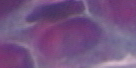

In [11]:
if len(images) > 0:
    from google.colab.patches import cv2_imshow
    cv2_imshow(images[0])
else:
    print("No images found in the directory.")

In [12]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Activation, Multiply, Add
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:


# Define data augmentation techniques
data_gen_args = ImageDataGenerator(rotation_range=30,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest', # Add a comma here
                    brightness_range=[0.8, 1.2], # Align with other arguments
                    preprocessing_function=lambda x: cv2.GaussianBlur(x, (3, 3), 0)) # Align with other arguments


train_gen = data_gen_args.flow(X_train, y_train_encoded, batch_size=16) # Change datagen to data_gen_args

In [14]:
# Initialize ImageDataGenerators for training images and masks
# Instead of get_config, directly pass the arguments
image_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=data_gen_args.rotation_range,
                                   width_shift_range=data_gen_args.width_shift_range,
                                   height_shift_range=data_gen_args.height_shift_range,
                                   shear_range=data_gen_args.shear_range,
                                   zoom_range=data_gen_args.zoom_range,
                                   horizontal_flip=data_gen_args.horizontal_flip,
                                   fill_mode=data_gen_args.fill_mode,
                                   brightness_range=data_gen_args.brightness_range,
                                   preprocessing_function=data_gen_args.preprocessing_function)
mask_datagen = ImageDataGenerator(rescale=1./255)



# Load training images and masks
image_generator_train = image_datagen.flow_from_directory(
    image_path,  # Path to training image directory
    target_size=(128, 128),  # Resize images to match model input size
    batch_size=32,
    class_mode=None,  # No labels for segmentation
    seed=42
)
mask_generator_train = mask_datagen.flow_from_directory(
    mask_path,  # Path to masks
    target_size=(128, 128),
    batch_size=32,
    color_mode='grayscale',  # Ensure masks are single-channel
    class_mode=None,
    seed=42
)



# Check the shape of the output from the generators
# Should print the shape of image and mask batches
images, masks = next(zip(image_generator_train, mask_generator_train))
print("Image shape:", images.shape)  # (batch_size, 128, 128, 3)
print("Mask shape:", masks.shape)  # (batch_size, 128, 128, 1)

# Combine image and mask generators for segmentation
train_generator = zip(image_generator_train, mask_generator_train)

Found 643 images belonging to 7 classes.
Found 643 images belonging to 7 classes.
Image shape: (32, 128, 128, 3)
Mask shape: (32, 128, 128, 1)


In [15]:
# Print the first batch of images and masks to verify compatibility
images, masks = next(train_generator)
print("Shape of images:", images.shape)  # Should be (batch_size, 128, 128, 3)
print("Shape of masks:", masks.shape)  # Should be (batch_size, 128, 128, 1)

Shape of images: (32, 128, 128, 3)
Shape of masks: (32, 128, 128, 1)


In [16]:
# Initialize ResNet-50 model for feature extraction
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
# Change input_shape to (128, 128, 3)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

# Adding custom layers for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Additional fully connected layer

# Final model for feature extraction
feature_extraction_model = Model(inputs=base_model.input, outputs=x)

# Freeze ResNet-50 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Extract features
# Changed line: Using 'feature_extraction_model' instead of 'resnet_model'
X_train_features = feature_extraction_model.predict(X_train)

21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

In [18]:
from tensorflow.keras.layers import Conv2D, Activation, Multiply, Add

def attention_block(x, gating, inter_channels):
    # 1x1 Conv for the input tensor
    theta_x = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)

    # 1x1 Conv for the gating tensor
    phi_g = Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(gating)

    # Sum the two feature maps
    concat_xg = Add()([theta_x, phi_g])
    concat_xg = Activation('relu')(concat_xg)

    # 1x1 Conv to reduce dimensionality
    psi = Conv2D(1, (1, 1), strides=(1, 1), padding='same')(concat_xg)
    psi = Activation('sigmoid')(psi)

    # Multiply attention map with the original input
    att_out = Multiply()([x, psi])
    return att_out


In [19]:
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, Input, BatchNormalization, Activation, Reshape, MaxPooling2D
# Ensure 'concatenate' is imported correctly
from keras.layers import concatenate  # or 'from tensorflow.keras.layers import concatenate'




def att_unet(input_size=(128, 128, 3), num_classes=7): # Assuming 7 classes in Herlev dataset
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up4 = UpSampling2D(size=(2, 2))(conv3)
    att4 = attention_block(conv2, up4, 128)
    # Pass the list of tensors to concatenate directly, with axis as a keyword argument
    concat4 = concatenate([att4, up4], axis=3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    att5 = attention_block(conv1, up5, 64)
    # Pass the list of tensors to concatenate directly, with axis as a keyword argument
    concat5 = concatenate([att5, up5], axis=3)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer - Multi-class
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(conv5)  # 'softmax' for multi-class

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [20]:
# Now, in your training code:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Change the filepath to end with '.keras' or set save_weights_only=True
model_checkpoint = ModelCheckpoint('best_model_herlev.keras', save_best_only=True)


In [21]:
import tensorflow as tf

def combine_generators(image_generator, mask_generator):
    """Combines image and mask generators into a single generator,
       and one-hot encodes the masks."""
    # Perform one-hot encoding outside the loop
    num_classes = 7  # Assuming you have 7 classes
    while True:  # Add this loop for continuous generation of batches
        for image_batch, mask_batch in zip(image_generator, mask_generator):
            mask_batch_encoded = tf.keras.utils.to_categorical(mask_batch, num_classes=num_classes)
            yield image_batch, mask_batch_encoded
    # Explicitly return None when the loop is broken to handle cases where data runs out.
    # This should not be reached if the loop is correctly structured but it can improve troubleshooting.
    return None

In [22]:
train_generator_combined = combine_generators(image_generator_train, mask_generator_train)


In [23]:
# Instantiate the model
model = att_unet(input_size=(128, 128, 3))

# Compile the model with categorical cross-entropy loss for multi class segmentation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(train_generator_combined , epochs=25, steps_per_epoch=len(image_generator_train), callbacks=[reduce_lr, early_stopping, model_checkpoint]) #

Epoch 1/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 746s 35s/step - accuracy: 0.8306 - loss: 0.7415 - learning_rate: 0.0010
Epoch 2/25


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 735s 35s/step - accuracy: 0.9991 - loss: 0.0304 - learning_rate: 0.0010
Epoch 3/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 737s 35s/step - accuracy: 0.9990 - loss: 0.0181 - learning_rate: 0.0010
Epoch 4/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 735s 35s/step - accuracy: 0.9989 - loss: 0.0221 - learning_rate: 0.0010
Epoch 5/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 737s 35s/step - accuracy: 0.9996 - loss: 0.0082 - learning_rate: 0.0010
Epoch 6/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 736s 35s/step - accuracy: 0.9987 - loss: 0.0148 - learning_rate: 0.0010
Epoch 7/25
21/21 ━━━━━━━━━━━━━━━━━━━━ 735s 35s/step - accuracy: 0.9985 - loss: 0.0192 - learning_rate: 0.0010
Epoch 8/25
